In [1]:
import numpy as np
import torch 
import torch.nn as nn 
import torchvision 
from torch.utils.data import DataLoader, TensorDataset 
from sklearn.mixture import GaussianMixture 
import matplotlib.pyplot as plt 
import tqdm 

torch.manual_seed(1)
np.random.seed(1)

**Instruções gerais:** Sua submissão <u>deve</u> conter: 
1. Um "ipynb" com seu código e as soluções dos problemas
2. Uma versão pdf do ipynb

Caso você opte por resolver as questões de "papel e caneta" em um editor de $\LaTeX$ externo, o inclua no final da versão pdf do 'ipynb'--- submetendo um <u>único pdf</u>.

# Trabalho de casa 08: K-means e Mixture models

## Exercícios práticos

### Ler os dados 

In [2]:
mnist_trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, 
                                            transform=torchvision.transforms.ToTensor())
fashion_mnist_trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, 
                                                           transform=torchvision.transforms.ToTensor()) 

mnist_testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, 
                                            transform=torchvision.transforms.ToTensor())

In [3]:
def display_nine_images(dataset):
    for i, (image, label) in enumerate(dataset): 
        plt.subplot(3, 3, i + 1) 
        plt.imshow(image.permute(1, 2, 0), cmap='gray')
        plt.axis('off')
        plt.title(f'Label: {label}') 
        if i >= 8: break 
    plt.suptitle(dataset.__class__.__name__) 
    plt.tight_layout()  

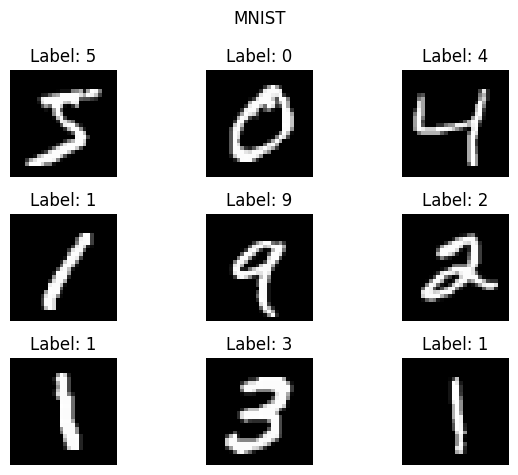

In [4]:
display_nine_images(mnist_trainset)

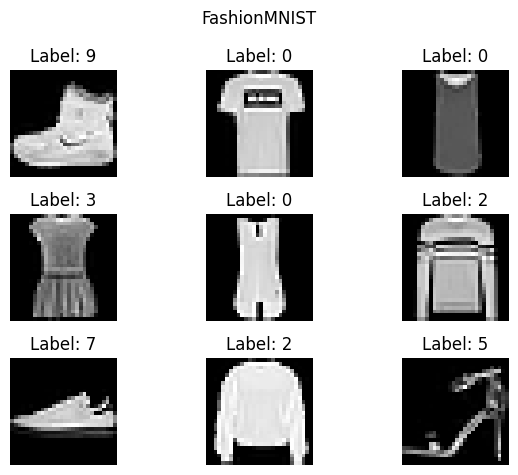

In [5]:
display_nine_images(fashion_mnist_trainset)

**1.** Implemente o algoritmo de $K$-means e aplique-o ao MNIST usando $K=10$ (o número de dígitos no banco de dados) --- inicializando os centroides aleatoriamente ou usando a estratégia do k-means++. Considere também inicializar os centróides como as médias das imagens de cada classe (é possível já que MNIST possui labels). Em geral, imagens similares são agrupadas junto? Plote exemplos de amostras em cada cluster.

In [6]:
class KMeans: 
    def __init__(self, n_clusters, max_iter=100, device: str = None, seed: int = None):
        self.n_clusters = n_clusters 
        self.max_iter = max_iter 
        self.device = torch.device(device) if device else torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.centroids = None
        self.labels = None
        if seed is not None: 
            np.random.seed(seed)
            torch.manual_seed(seed)
        if torch.cuda.is_available(): # GPU
            torch.set_default_device('cuda')
    
    def kmeans_pp(self, X):
    # Aplica o algoritmo Kmeans++ para inicializar os centroides
        centroids = torch.zeros(self.n_clusters, X.size(1))
        chosen = torch.tensor(np.random.choice(len(X), 1))
        centroids[0] = X[chosen]
        for i in range(1, self.n_clusters):
            distances = torch.cdist(X, centroids[:i])
            probabilities = (distances ** 2).min(dim=1)[0].cpu().numpy()
            probabilities[chosen.cpu().numpy()] = 0
            probabilities /= probabilities.sum()
            chosen = torch.tensor(np.random.choice(len(X), 1, p=probabilities))
            centroids[i] = X[chosen]
        return centroids
        
        
    def fit(self, X: torch.Tensor, targets: torch.Tensor = None, init: str = None):
        X = X.to(self.device)
        if init == "random_centroids":
            # Inicializa os centroides aleatoriamente
            self.centroids = X[torch.tensor(np.random.choice(len(X), self.n_clusters, replace=False))]
        elif init == "kmeans++":
            # Inicializa os centroides usando o algoritmo KMeans++
            self.centroids = self.kmeans_pp(X)
        elif init == "mean":
            # Inicializa os centroides como as médias das imagens de cada classe
            self.centroids = torch.zeros(self.n_clusters, X.size(1))
            for i in range(self.n_clusters):
                self.centroids[i] = X[targets == i].mean(dim=0)
        else:
            raise ValueError("init deve ser 'random_centroids' ou 'kmeans++'")

        for i in tqdm.tqdm(range(self.max_iter), desc='Iteração'):
            old_centroids = self.centroids.clone() 
            distances = torch.cdist(X, self.centroids)
            new_labels = torch.argmin(distances, dim=1)
            for j in range(self.n_clusters):
                self.centroids[j] = X[new_labels == j].mean(dim=0)

            if torch.all(old_centroids == self.centroids):
                print(f'Convergiu na iteração {i}')
                break
        self.labels = new_labels

    def plot_centroids(self):
        plt.figure(figsize=(13, 2))
        for i in range(self.n_clusters):
            plt.subplot(1, self.n_clusters, i + 1)
            plt.imshow(self.centroids[i].cpu().numpy().reshape(28, 28), cmap='gray')
            plt.axis('off')
            plt.title(f'Cluster {i}')
        plt.suptitle('K-Means Centroids')
        plt.show()

    def plot_clusters(self, X):
        X, labels = X.cpu(), self.labels.cpu()
        plt.figure(figsize=(10, 10))
        for i in range(self.n_clusters):
            cluster_images = X[labels == i][:10]
            for j, image in enumerate(cluster_images):
                plt.subplot(10, self.n_clusters, i + j * self.n_clusters + 1)
                plt.imshow(image.numpy().reshape(28, 28), cmap='gray')
                plt.axis('off')
                if j == 0:
                    plt.title(f'Cluster {i}')
        plt.suptitle('K-Means Clusters')
        plt.tight_layout()
        plt.show()

Vamos plotar os centroides e as imagens mais próximas de cada cluster. Começamos inicializando os centroides aleatoriamente.

Iteração:  62%|██████▏   | 62/100 [00:03<00:02, 18.45it/s]


Convergiu na iteração 62


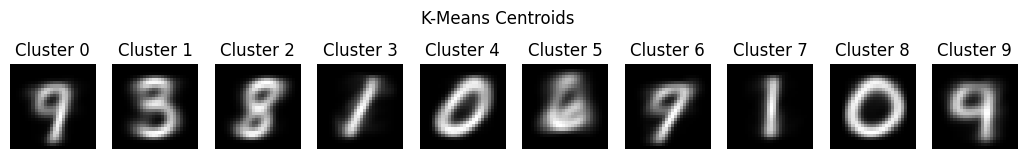

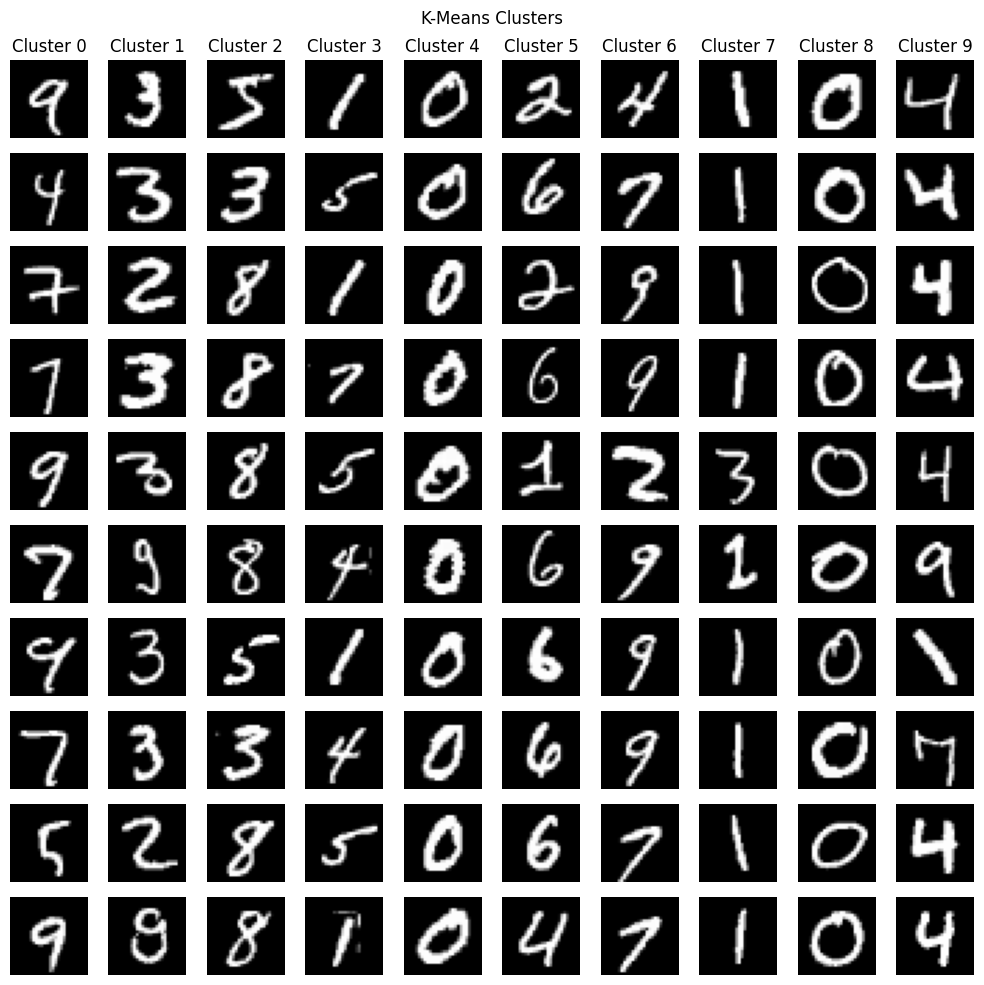

In [7]:
data, targets = mnist_trainset.data.flatten(1).float(), mnist_trainset.targets
kmeans = KMeans(n_clusters=10, seed=42)
kmeans.fit(data, targets, init="random_centroids") # Inicializa os centroides aleatoriamente

kmeans.plot_centroids()
kmeans.plot_clusters(data)

Agora inicializamos os centroides com o k-means++.

Iteração:  94%|█████████▍| 94/100 [00:01<00:00, 80.76it/s]


Convergiu na iteração 94


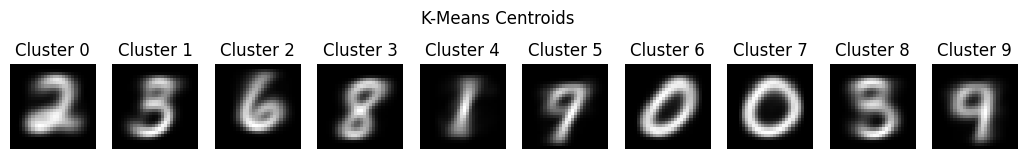

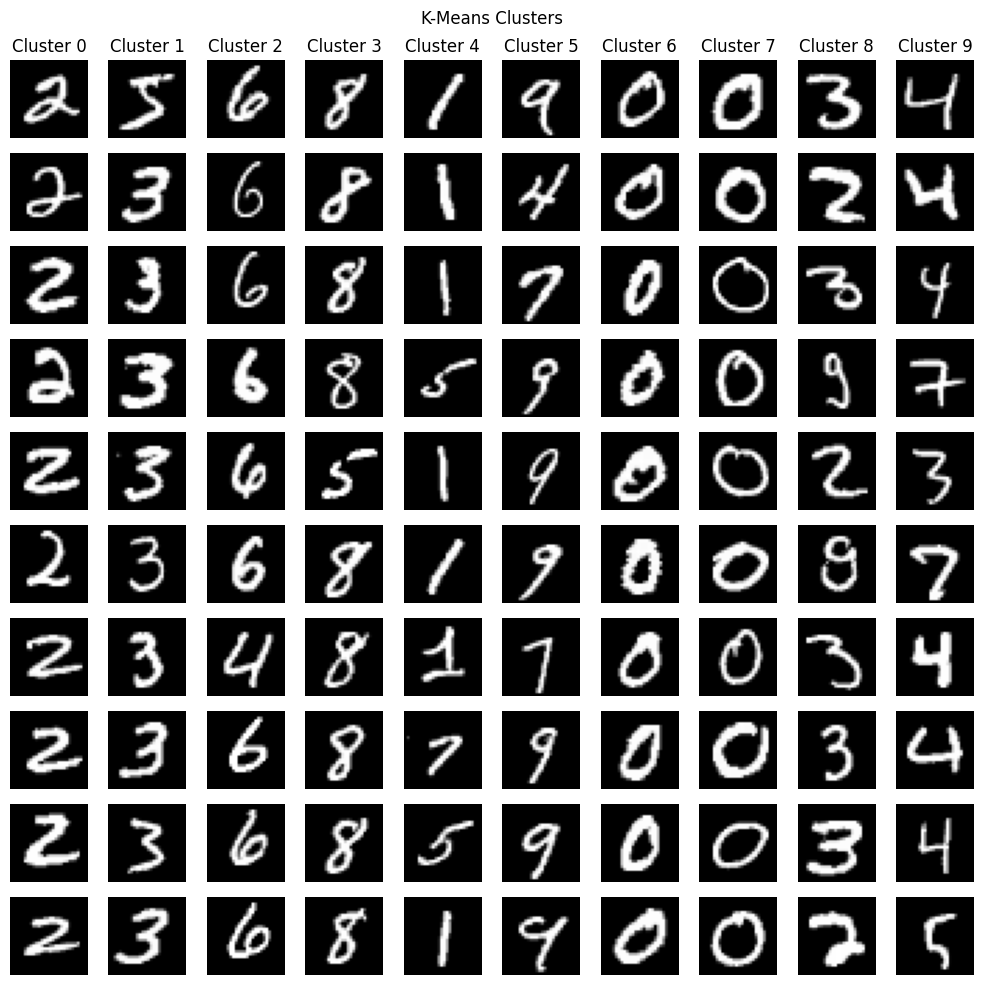

In [8]:
data, targets = mnist_trainset.data.flatten(1).float(), mnist_trainset.targets
kmeans = KMeans(n_clusters=10, seed=42)
kmeans.fit(data, targets, init="kmeans++") # Inicializa os centroides usando o algoritmo KMeans++
kmeans.plot_centroids()
kmeans.plot_clusters(data)

Por fim, vamos inicializar os centroides com as médias das imagens de cada classe.

Iteração:   0%|          | 0/200 [00:00<?, ?it/s]

Iteração:  92%|█████████▏| 183/200 [00:02<00:00, 81.15it/s]


Convergiu na iteração 183


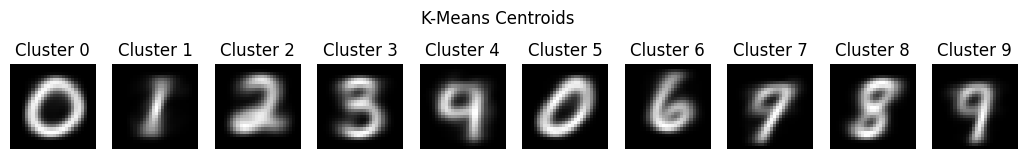

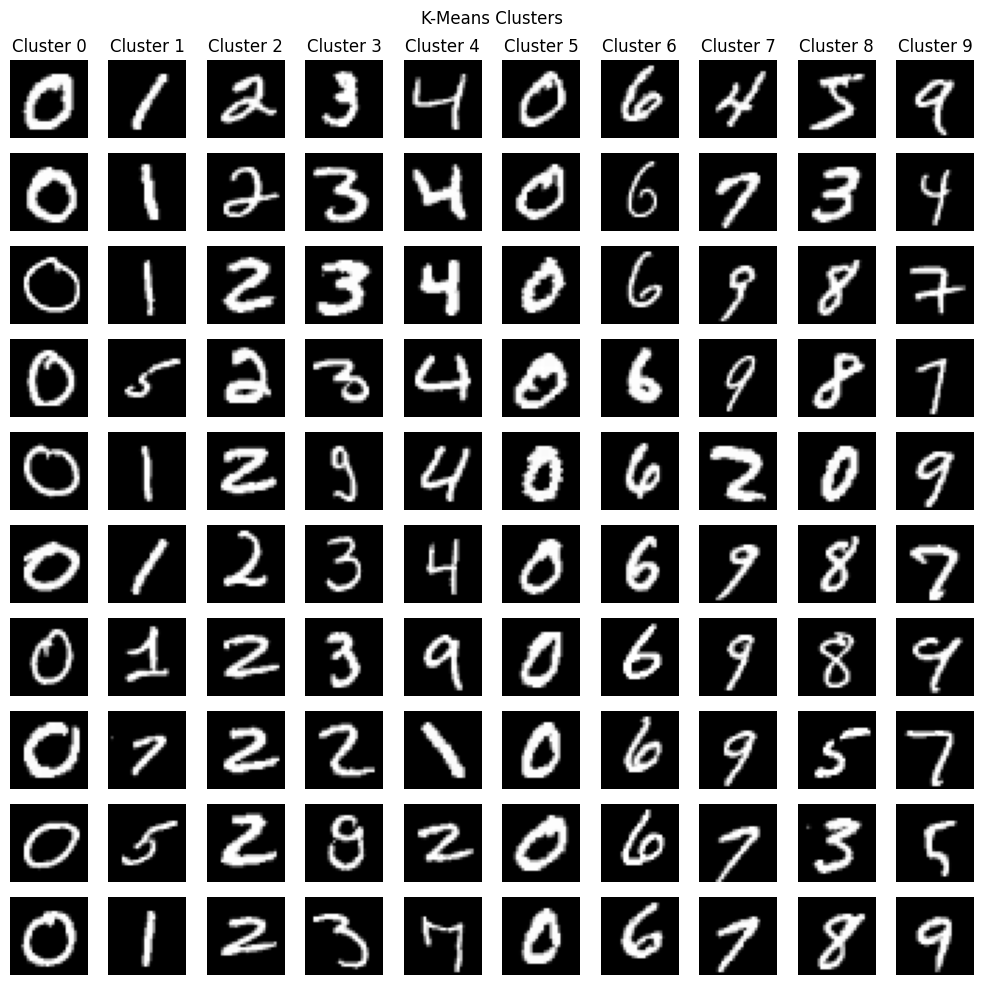

In [9]:
data, targets = mnist_trainset.data.flatten(1).float(), mnist_trainset.targets
kmeans = KMeans(n_clusters=10, max_iter=200, seed=42)
kmeans.fit(data, targets, init="mean") # Inicializa os centroides como as médias das imagens de cada classe
kmeans.plot_centroids()
kmeans.plot_clusters(data)

No geral, imagens similares são agrupadas no mesmo cluster. Vimos que a inicialização aleatória tem resultados piores do que a inicialização pelo algoritmo kmeans++. A inicialização com as médias das imagens de cada classe também pode ser útil, mas é mais sensível a outliers. Note que todas as inicializações tiveram dificuldades em identificar o cluster 5 e 9.

**2.** Gaussian Mixture Models (GMMs) são estimadores de densidade poderosos. Podemos utilizá-los, por exemplo, para detectar amostras "fora da distribuição de treino" (out-of-distribution, OOD) em tempo de teste, evitando possíveis previsões catastróficias. Com isso em mente, treine um MLP para classificar o MNIST. Com o MLP treinado, use um GMM para modelar as ativações da penúltima camada desse MLP (usando as ativações dos dados de treino). Agora, avalie a capacidade dessa GMM diferenciar amostras de test do MNIST e do FashionMNIST (espera-se que amostras OOD --- do Fashin MNIST--- estejam nas caudas). Teste essa estratégia com números diferentes de componente das misturas e escolha a que provê a melhor separação. Para simplificar sua vida, use a implementação de GMM do scikit-learn.

In [10]:
# Gaussian Mixture Models
class MLP(nn.Module):
    def __init__(self, input_size: int = 784, hidden_size: int = 100, num_classes: int = 10, device: str = None,
                num_epochs: int = 10, lr: float = 0.001, weight_decay: float = 0.01, batch_size: int = 1024, seed: int = 42):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size,  hidden_size //2),
            nn.ReLU(),
            nn.Linear(hidden_size //2, hidden_size //4),
            nn.SiLU(),
            nn.Linear(hidden_size //4, num_classes),
        ])

        self.criterion = nn.CrossEntropyLoss()
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.lr = lr
        self.weight_decay = weight_decay
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)
        self.device = device
        self.seed = seed
        self.train_losses = []
        if torch.cuda.is_available(): # GPU
            torch.set_default_device('cuda')
        if seed is not None: 
            np.random.seed(seed)
            torch.manual_seed(seed)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        for layer in self.layers:
            x = layer(x)
        return x

    def fit(self, train_set):
        train_loader = DataLoader(train_set, batch_size=self.batch_size, shuffle=True, generator=torch.Generator(device=self.device))
        for epoch in range(self.num_epochs):
            run_loss = 0
            iterate = tqdm.tqdm(train_loader, desc=f'Epoch [{epoch+1}/{self.num_epochs}]')
            for images, labels in iterate:
                images, labels = images.to(self.device), labels.to(self.device)
                self.optimizer.zero_grad()
                # Forward pass
                outputs = self(images)
                loss = self.criterion(outputs, labels)
                # Backward pass and optimize
                loss.backward()
                self.optimizer.step()
                self.train_losses.append(loss.item())
                run_loss += loss.item()
                iterate.set_postfix(loss=run_loss/len(train_loader))

    def predict(self, test_set):
        test_loader = DataLoader(test_set, batch_size=self.batch_size, shuffle=True, generator=torch.Generator(device=self.device))
        self.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        print(f'Accuracy: {100 * correct / total:.2f}%')

    def get_penultimate_activations(self, dataset, device):
        self.eval()
        activations = []
        loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=False)
        with torch.no_grad():
            for images, _ in loader:
                images = images.to(device)
                x = images.view(images.size(0), -1)
                for layer in self.layers[:-1]:  # Exclude the last layer
                    x = layer(x)
                activations.append(x.cpu().numpy())
        return np.vstack(activations)

In [11]:
batch_size = 1024
lr = 0.001
weight_decay = 0.001
num_epochs = 20
seed = 42
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = MLP(num_epochs=num_epochs, lr=lr, weight_decay=weight_decay, batch_size=batch_size, device=device, seed=seed)

Vamos treinar a MLP e usar um GMM para modelar as ativações da penúltima camada. Em seguida, vamos avaliar a capacidade dessa GMM diferenciar amostras de teste do MNIST e do FashionMNIST.

In [12]:
model.fit(mnist_trainset)
torch.save(model.state_dict(), 'mlp_mnist.pth')
model.predict(mnist_testset)

Epoch [20/20]: 100%|██████████| 59/59 [00:07<00:00,  8.37it/s, loss=0.0843]


Accuracy: 96.72%


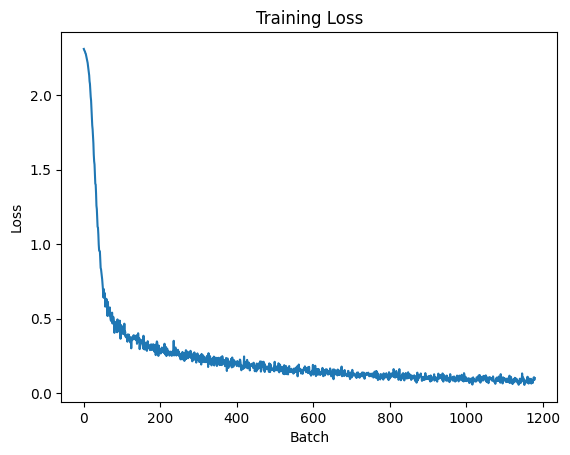

In [13]:
# Plot the training loss
plt.figsize=(6, 5)
plt.plot(model.train_losses)
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [14]:
from sklearn.metrics import roc_auc_score, accuracy_score
# Get penultimate layer activations
mnist_activations = model.get_penultimate_activations(mnist_testset, device)
fashion_activations = model.get_penultimate_activations(fashion_mnist_trainset, device)

# Fit GMM on MNIST activations
num_components = range(1, 21)
auc_scores, accuracies = [], []
best_gmm_score, best_gmm_auc, best_gmm_acc = None, None, None
best_score, best_auc, best_acc = -np.inf, -np.inf, -np.inf

for n in tqdm.tqdm(num_components, desc='Component'):
    gmm = GaussianMixture(n_components=n, random_state=seed)
    gmm.fit(mnist_activations)
    # GMM score
    mnist_prob = gmm.score_samples(mnist_activations)
    fashion_prob = gmm.score_samples(fashion_activations)
    # AUC score
    combined_scores = np.concatenate([mnist_prob, fashion_prob])
    labels = np.concatenate([np.zeros_like(mnist_prob), np.ones_like(fashion_prob)])
    auc = roc_auc_score(labels, combined_scores)
    auc_scores.append(auc)
    # Accuracy
    threshold = np.median(combined_scores)
    predicted_labels = (combined_scores > threshold).astype(int)
    accuracy = accuracy_score(labels, predicted_labels)
    accuracies.append(accuracy)

    if mnist_prob.mean() > best_score:
        best_score = mnist_prob.mean()
        best_gmm_score = gmm

    if auc >= best_auc:
        best_auc = auc
        best_gmm_auc = gmm

    if accuracy > best_acc:
        best_acc = accuracy
        best_gmm_acc = gmm

# Evaluate GMM on MNIST and FashionMNIST activations
mnist_scores = best_gmm_score.score_samples(mnist_activations)
fashion_scores = best_gmm_score.score_samples(fashion_activations)

# Print results
print(f'Best number of components: {best_gmm_score.n_components}')
print(f'MNIST scores: {mnist_scores.mean():.2f} ± {mnist_scores.std():.2f}')
print(f'FashionMNIST scores: {fashion_scores.mean():.2f} ± {fashion_scores.std():.2f}')

print(f'Best accuracy: {best_acc:.2f}')
print(f'Best number of components based on accuracy: {best_gmm_acc.n_components}')
print(f'Best AUC: {best_auc:.2f}')
print(f'Best number of components based on AUC: {best_gmm_auc.n_components}')

Component:  30%|███       | 6/20 [00:20<01:04,  4.60s/it]

Component: 100%|██████████| 20/20 [03:44<00:00, 11.21s/it]


Best number of components: 20
MNIST scores: 5.20 ± 10.72
FashionMNIST scores: -14.39 ± 13.58
Best accuracy: 0.46
Best number of components based on accuracy: 1
Best AUC: 0.40
Best number of components based on AUC: 1


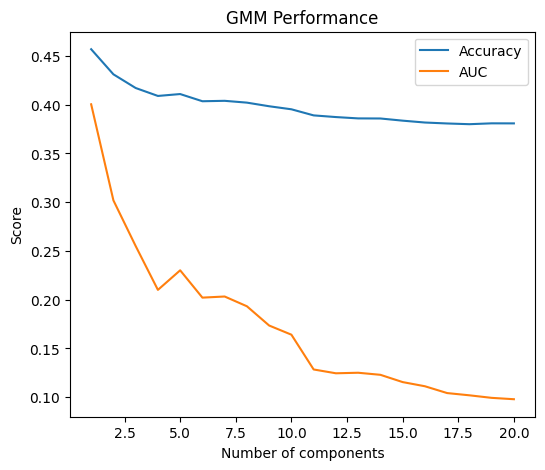

In [15]:
# plot accuracies and auc 
plt.figure(figsize=(6, 5))
plt.plot(num_components, accuracies, label='Accuracy')
plt.plot(num_components, auc_scores, label='AUC')
plt.xlabel('Number of components')
plt.ylabel('Score')
plt.title('GMM Performance')
plt.legend()
plt.show()

A performance do GMM foi avaliada usando a métrica AUC e acurácia. Apesar de não ser satisfatória, a melhor performance foi obtida com 20 e 1 componentes respectivamente. 

**1.** Como vimos anteriormente, a função custo para $k$-means é:
\begin{equation}
    \sum_{i=1\ldots K} \sum_{x \in C_i} \| x - \mu_i \|_2^2,
\end{equation}
a qual otimizamos atualizando os clusters e seus respectivos centróides de maneira alternada. Suponha, no entanto, que nosso banco de dados contém entradas faltantes, i.e., existe algum vetor $x=[x_1, \ldots, x_D]$ para o qual apenas as entradas $x_o \forall o(x) \in O(x) \subseteq \{1,\ldots,D\}$ foram observadas. Deixe, similarmente, que $M(x)$ denote o conjunto de índices faltantes em $x$. Existem várias maneiras de contornar esse problema. A mais animalesca (e que descarta menos informação) é jogar fora amostras com entradas faltantes. Pode-se também pré-processar o banco de dados para preencher os valores faltantes. Uma terceira opção é codificar nossa incerteza sobre $x_{M(x)}$ como uma distribuição e propagar essa incerteza pela nossa função custo. Caso não saibamos muito sobre esses valores faltantes, por exemplo, podemos atribuir uma Gaussiana com média zero e variância $c>0$ para cada $x_m \forall m \in M(x)$. Nesse caso, nossa função custo se transforma em: 
\begin{equation}
    \sum_{i=1\ldots K} \sum_{x \in C_i} \mathbb{E}_{x_{M(x)} \sim N\left(0, c I_{|M(x)|}\right)}\big[\| x - \mu_i \|_2^2\big],
\end{equation}

Derive algoritmo para otimizar a função acima --- de maneira similar à que derivamos o $k$-means. Comente como seu algoritmo difere do $K$-means original.

**Resposta:** 

1. Inicialize os centróides $\mu_1$, $\ldots$, $\mu_K$ aleatoriamente ou usando a estratégia do k-means++.

2. Considere uma função indicadora $y_{n,k}$ tal que
$
y_{n,k}= \begin{cases}1, & \text { se } x_n \text { pertence ao cluster } k, \\ 0, & \text { caso contrário. }\end{cases}
$

A função custo para o $K$-means com valores faltantes se torna:
$$
J=\sum_{n=1}^N \sum_{k=1}^K y_{n,k} \mathbb{E}_{x_{M(x)} \sim N\left(0, c I_{|M(x)|}\right)}\left[\left\|x_n-\mu_k\right\|_2^2\right] 
$$

3. Minimizamos $J$ em relação a $y_{nk}$ fixando $\mu_k$.  Isso significa atribuir cada ponto de dados $x_n$ ao cluster cujo centróide minimiza a expectativa da distância quadrática entre $x_n$ e $\mu_k$

$$
y_{n,k}= \begin{cases}1, & \text { se } k=\arg \min _{k^{\prime}} \mathbb{E}_{x_{M(x)} \sim N\left(0, c I_{\mid M(x)}\right)}\left[\left\|x_n-\mu_{k^{\prime}}\right\|_2^2\right] \\ 0, & \text { caso contrário. }\end{cases}
$$
Para calcular $\mathbb{E}\left[\left\|x_n - \mu_k||\right\|_2^2\right]$, temos que separar $x_n$ em partes observadas $x_{O(x)}$ e faltaantes $x_{M(x)}$. E também $\mu_k$ em $\mu_{O(\mu_k)}$ e $\mu_{M(\mu_k)}$. Assim, temos que:

$$\mathbb{E}_{x_{M(x)} \sim N\left(0, c I_{\mid M(x)}\right)}\left[\left\|x_n-\mu_{k^{\prime}}\right\|_2^2\right] = \left\|x_{O(x)}-\mu_{O(\mu_{k^{\prime}})}\right\|_2^2 + \sum_{m \in M(x)} (\mu_{k,m}^2 + c)$$

Onde $c$ é a variância da distribuição Gaussiana que modela os valores faltantes.

4. Minimizamos $J$ em relação a $\mu_k$, fixando $r_{n k}$. Basta derivarmos $J$ em relação a $\mu_k$ e igualarmos a zero. 
$$
\begin{aligned}
& \sum_{n=1}^N \sum_{k=1}^K y_{n,k} \mathbb{E}_{x_{M(x)} \sim N\left(0, c I_{|M(x)|}\right)}\left[\frac{\partial}{\partial \mu_k}\left\|x_n-\mu_k\right\|_2^2\right]=0 \\ & \Leftrightarrow-2 \sum_{n=1}^N y_{n,k} \space \mathbb{E}_{x_{M(x)} \sim N\left(0, c I_{|M(x)|}\right)}\left[x_n-\mu_k\right]=0 \\
& \Leftrightarrow \sum_{n=1}^N y_{n,k} \space \mathbb{E}_{x_{M(x) \sim N}\left(0, c I_{|M(x)|}\right)}\left[x_n\right]=\sum_{n=1}^N y_{n,k} \mathbb{E}_{x_{M(x) \sim N(0, c c|M(x)|)}}\left[\mu_k\right] \\
& \Leftrightarrow \mu_k=\frac{\sum_{n=1}^N y_{n,k} \mathbb{E}_{x_{M(x) \sim N}\left(0, c I_{|M(x)|}\right)}\left[x_n\right]}{\sum_{n=1}^N y_{n,k}} 
\end{aligned}
$$

Para calcular $E[x_n]$, observamos que para os valores faltantes $x_{M(x)}$, a expectativa é zero (pois $x_{M(x)} \sim N(0, c I_{|M(x)|})$). Logo,

$E[x_n] = \begin{cases}
x_{O(x)}, & \text{se } x_d \text{ é observado} \\
0, & \text{se } x_d \text{ é faltante}
\end{cases}$

Portanto, a atualização dos centróides $\mu_k$ se torna:

$$
\mu_k=\frac{\sum_{n=1}^N y_{n,k} x_{n, d}}{\sum_{n=1}^N y_{n,k}}
$$

Onde $x_{n,d} = 0$ se $d \in M(x_n)$ e $x_{n,d}$ observado se $d \in O(x_n)$.

5. Repita os Passos 3 e 4 até que os centróides $\mu_k$ convirjam (ou a mudança seja menor que um limiar definido).

Conclusões: Diferente do $K$-means original, que assume que todos os valores são observados, no novo algoritmo, lidamos explicitamente com valores faltantes. Para isso, modelamos a incerteza sobre os valores faltantes como uma distribuição Gaussiana com média zero e variância $c$.

**2.** Na aula, motivamos o uso de _Gaussian Mixture Models_ (GMMs) e discutimos como estimar seus parâmetros via máxima verossimilhança. Mais especificamente, começamos a derivar um algoritmo de _coordinate ascent_ para maximizar a verossimilhança. Siga os passos da Seção 9.2 (página 430) do [_Pattern Recognition and Machine Learning_ (C. Bishop)](https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf) e mostre a derivação passo-a-passo (boa parte está omitida no livro) do algoritmo.

**Resposta:** Tome uma amostra $X=\left(X_1, X_2, \ldots, X_n\right)$ de uma mistura gaussiana de $K$ componentes, onde a densidade de probabilidade de cada componente é dada por:
$$
p(x \mid \pi, \mu, \Sigma)=\sum_{k=1}^K \pi_k \mathcal{N}\left(x \mid \mu_k, \Sigma_k\right)
$$

1. Vamos derivar a log-verossimilhança com respeito a $\mu_k$ e igualar a zero:
$$
\frac{\partial}{\partial \mu_k} l(X \mid \pi, \mu, \Sigma) =\sum_{i=1}^n \frac{\partial}{\partial \mu_k} \log \left[\sum_{k=1}^K \pi_k \mathcal{N}\left(X_i \mid \mu_k, \Sigma_k\right)\right] 
$$
Expandindo essa derivada,
$$\sum_{i=1}^n \frac{\frac{\partial}{\partial \mu_k} \sum_{j=1}^K \pi_j \mathcal{N}\left(X_i \mid \mu_j, \Sigma_j\right)}{\sum_{j=1}^K \pi_j \mathcal{N}\left(X_i \mid \mu_j, \Sigma_j\right)}=0$$
$$\sum_{i=1}^n \frac{\pi_k \frac{\partial}{\partial \mu_k} \mathcal{N}\left(X_i \mid \mu_k, \Sigma_k\right)}{\sum_{j=1}^K \pi_j \mathcal{N}\left(X_i \mid \mu_j, \Sigma_j\right)}=0$$
$$\sum_{i=1}^n \frac{\pi_k \frac{\partial}{\partial \mu_k}(2 \pi)^{-k / 2} \operatorname{det}\left(\Sigma_k\right)^{-1 / 2} \exp \left(-\frac{1}{2}\left(x-\mu_k\right)^{\top} \Sigma_k^{-1}\left(x-\mu_k\right)\right)}{\sum_{j=1}^K \pi_j \mathcal{N}\left(X_i \mid \mu_j, \Sigma_j\right)}=0
$$
Levando em conta a forma da densidade gaussiana, temos:
$$
\begin{aligned}
\Leftrightarrow & -\sum_{i=1}^n \frac{\pi_k \mathcal{N}\left(X_i \mid \mu_k, \Sigma_k\right)}{\sum_{j=1}^K \pi_j \mathcal{N}\left(X_i \mid \mu_j, \Sigma_j\right)} \Sigma_k^{-1}\left(X_i-\mu_k\right)=0
\end{aligned}
$$

Definindo $\gamma_{i k}=\frac{\pi_k \mathcal{N}\left(X_i \mid \mu_k, \Sigma_k\right)}{\sum_{j=1}^K \pi_j \mathcal{N}\left(X_i \mid \mu_j, \Sigma_j\right)}$, temos
$$
\sum_{i=1}^n \gamma_{i k}\left(X_i-\mu_k\right)=0
$$
Resolvendo para $\mu_k$, obtemos:
$$
\mu_k=\frac{\sum_{i=1}^n \gamma_{i k} X_i}{\sum_{i=1}^n \gamma_{i k}}
$$

2. Agora, vamos derivar a log-verossimilhança com respeito a $\Sigma_k$ e igualar a zero:
$$
\sum_{i=1}^n \frac{\pi_k \frac{\partial}{\partial \Sigma_k}(2 \pi)^{-k / 2} \operatorname{det}\left(\Sigma_k\right)^{-1 / 2} \exp \left(-\frac{1}{2}\left(x-\mu_k\right)^{\top} \Sigma_k^{-1}\left(x-\mu_k\right)\right)}{\sum_{j=1}^K \pi_j \mathcal{N}\left(X_i \mid \mu_j, \Sigma_j\right)}=0$$
$$-\sum_{i=1}^n \gamma_{i k}\left[\Sigma_k^{-1}-\Sigma_k^{-1}\left(X_i-\mu_k\right)\left(X_i-\mu_k\right)^T \Sigma_k^{-1}\right]=0
$$

$$\sum_{i=1} \gamma_{i k}\left[\Sigma_k-\left(X_i-\mu_k\right)\left(X_i-\mu_k\right)^T\right]=0$$
$$\Sigma_k=\frac{\sum_{i=1}^n \gamma_{i k}\left(X_i-\mu_k\right)\left(X_i-\mu_k\right)^T}{\sum_{i=1}^n \gamma_{i k}}$$

3. Só falta derivar a log-verossimilhança com respeito a $\pi_k$ sujeito a $\sum_{k=1}^K \pi_k=1$. Por lagrange, temos que:
$$
\mathcal{L}(\pi, \lambda)=\sum_{i=1}^n \log \left[\sum_{k=1}^K \pi_k \mathcal{N}\left(X_i \mid \mu_k, \Sigma_k\right)\right]+\lambda\left(1-\sum_{k=1}^K \pi_k\right)
$$
Daí,
$$
\frac{\partial \mathcal{L}}{\partial \pi_k}=\sum_{i=1}^n \frac{\mathcal{N}\left(X_i \mid \mu_k, \Sigma_k\right)}{\sum_{j=1}^K \pi_j \mathcal{N}\left(X_i \mid \mu_j, \Sigma_j\right)}+\lambda=0$$
$$ \sum_{i=1}^n \gamma_{i k}+\pi_k \lambda=0$$
$$ \lambda=-\sum_{k=1}^K \sum_{i=1}^n \gamma_{i k} =-\sum_{i=1}^n \frac{\sum_{k=1}^K \pi_k \mathcal{N}\left(X_i \mid \mu_k, \Sigma_k\right)}{\sum_{j=1}^K \pi_j \mathcal{N}\left(X_i \mid \mu_j, \Sigma_j\right)}=-n
$$

Logo,
$$
\pi_k=\frac{1}{n} \sum_{i=1}^n \gamma_{i k}
$$